# Simulating circuits with OBP

In this guide, you will learn how to simulate `QuantumCircuit` instances entirely through the means of OBP.

Since OBP will take an observable and backpropagate it through a given circuit, the "simulation" of a circuit amounts to computing the expectation value of the target observable with respect to this circuit.
As you will see later, the `qiskit-addon-obp` package is even capable of handling simple noise models, allowing you to compute noisy expectation values, too!

## Constructing an example circuit

For the purposes of this guide, we will use the same example circuit as in the [Pauli term truncation guide](https://qiskit.github.io/qiskit-addon-obp/how_tos/truncate_operator_terms.html):

In [1]:
import rustworkx.generators
from qiskit.synthesis import LieTrotter
from qiskit_addon_utils.problem_generators import (
    PauliOrderStrategy,
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import combine_slices, slice_by_gate_types

# we generate a linear chain of 10 qubits
num_qubits = 10
linear_chain = rustworkx.generators.path_graph(num_qubits)

# we use an arbitrary XY model
hamiltonian = generate_xyz_hamiltonian(
    linear_chain,
    coupling_constants=(0.05, 0.02, 0.0),
    ext_magnetic_field=(0.02, 0.08, 0.0),
    pauli_order_strategy=PauliOrderStrategy.InteractionThenColor,
)
# we evolve for some time
circuit = generate_time_evolution_circuit(hamiltonian, synthesis=LieTrotter(reps=3), time=2.0)
# slice the circuit by gate type
slices = slice_by_gate_types(circuit)

But this time around, we insert a custom initial state at the front.
Here, we simply do so by inserting the state preparation circuit at the front of our `slices`:

In [2]:
from qiskit.circuit import QuantumCircuit

initial_state = QuantumCircuit(num_qubits)
for i in range(0, num_qubits, 2):
    initial_state.x(i)

slices.insert(0, initial_state)

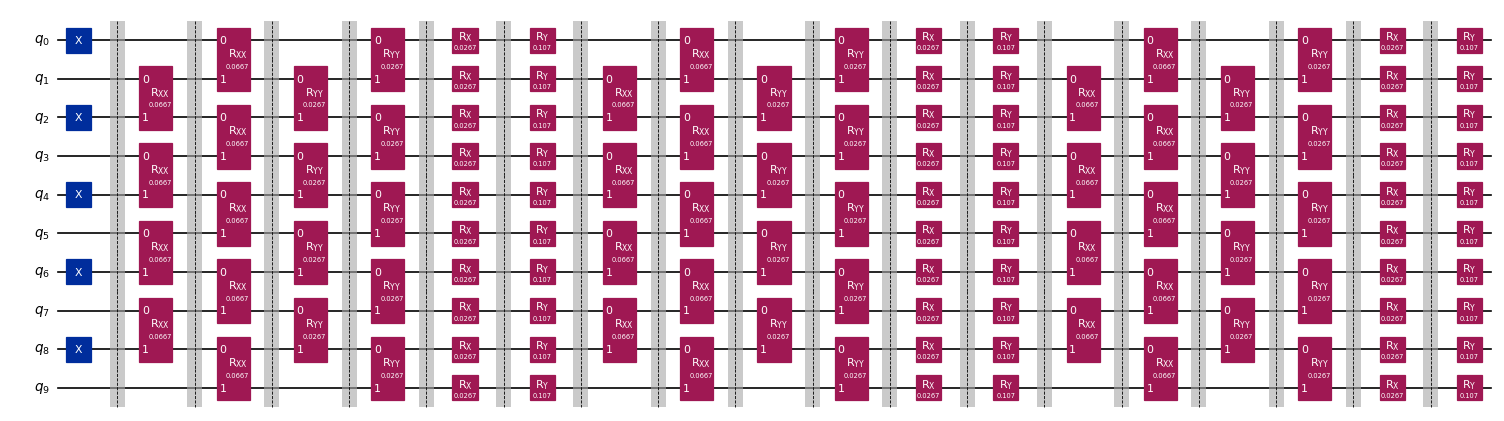

In [3]:
# for visualization purposes only, we recombine the slices with barriers between them and draw the resulting circuit
combine_slices(slices, include_barriers=True).draw("mpl", fold=50, scale=0.6)

## Computing a noiseless expectation value

As our target observable, we choose the `ZZ` observable on the central qubits:

In [4]:
from qiskit.quantum_info import SparsePauliOp

obs = SparsePauliOp("IIIIZZIIII")

At this point, we are already set to compute the expectation value using OBP.
To do so, we simply provide the _all_ the slices to the `backpropagate` method, like so:

In [5]:
from qiskit_addon_obp import backpropagate

vacuum_state_obs, _, metadata = backpropagate(obs, slices)

We have now backpropagated our target observable `obs` through the _entire_ circuit, resulting in a new `SparsePauliOp` whose expectation value we obtain by projecting it on the _vacuum state_ (`|00...00>`).
This can be achieved in a straight forward manner by summing up the coefficients of all Pauli terms defined in the computational basis:

In [6]:
vacuum_state_obs.coeffs[~vacuum_state_obs.paulis.x.any(axis=1)].sum()

np.complex128(-0.8285688012239535+4.9487770271457865e-20j)

As a sanity check (and to proof that this works) we can compare our result against Qiskit's `Statevector`:

In [7]:
from qiskit.quantum_info import Statevector

Statevector(combine_slices(slices)).expectation_value(obs)

np.complex128(-0.8285687255430366+0j)

## Computing a noisy expectation value

The `qiskit-addon-obp` package also supports handling of noise models in the form of `PauliLindbladError`s.
This is especially useful when you characterized the noise model of the 2-qubit layers in your circuit, for example using the [`NoiseLearner`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/noise-learner-noise-learner).

Below, we construct a random noise model of a similar form, to showcase how this capability can be used.
In practice, one would of course rely on actual noise model data and not this randomly generated one.

In [8]:
import numpy as np
from qiskit.quantum_info import PauliList
from qiskit_ibm_runtime.utils.noise_learner_result import PauliLindbladError

np.random.seed(42)
possible_pauli_errors = [
    "IX",
    "IY",
    "IZ",
    "XI",
    "YI",
    "ZI",
    "XX",
    "XY",
    "XZ",
    "YX",
    "YY",
    "YZ",
    "ZX",
    "ZY",
    "ZZ",
]

errors = []
for _ in range(num_qubits):
    # randomly sample how many Pauli error terms to include
    num_err_terms = np.random.randint(2, 5)
    # randomly sample which error terms to include
    err_indices = np.random.randint(0, len(possible_pauli_errors), size=num_err_terms)
    # randomly sample the error rates in an interval from 0.0005 to 0.02
    err_rates = 0.0005 + 0.02 * np.random.rand(num_err_terms)

    # construct the PLE
    err = PauliLindbladError(PauliList([possible_pauli_errors[i] for i in err_indices]), err_rates)

    errors.append(err)

Having obtained some noise model data, we wrap each noise operation into `PauliLindbladErrorInstruction` objects, a thin wrapper of the `PauliLindbladError` class provided by the OBP addon.

Note, that we expect native support of Pauli-Linblad errors by the Qiskit SDK in the (near-ish) future. Once that support exists, the OBP addon will strive towards updating this workflow in accordance.

In [9]:
from qiskit_addon_obp.utils.noise import PauliLindbladErrorInstruction

even_noise_slice = QuantumCircuit(num_qubits)
for i in range(0, num_qubits - 1, 2):
    even_noise_slice.append(PauliLindbladErrorInstruction(errors[i]), qargs=(i, i + 1))

odd_noise_slice = QuantumCircuit(num_qubits)
for i in range(1, num_qubits - 1, 2):
    odd_noise_slice.append(PauliLindbladErrorInstruction(errors[i]), qargs=(i, i + 1))

At this point, we have to insert our noisy operations into the circuit. Here, we have to do so manually as shown below.

Again, active work is being done on the Qiskit SDK to make handling of noise model data within circuits more seamless and we expect the interface and workflow to be updated accordingly.

In [10]:
noisy_slices = slices.copy()
for i in [1, 4, 9, 12, 17, 20]:
    noisy_slices.insert(i, odd_noise_slice)
for i in [3, 7, 13, 17, 23, 27]:
    noisy_slices.insert(i, even_noise_slice)

Again, we draw our circuit to check our work:

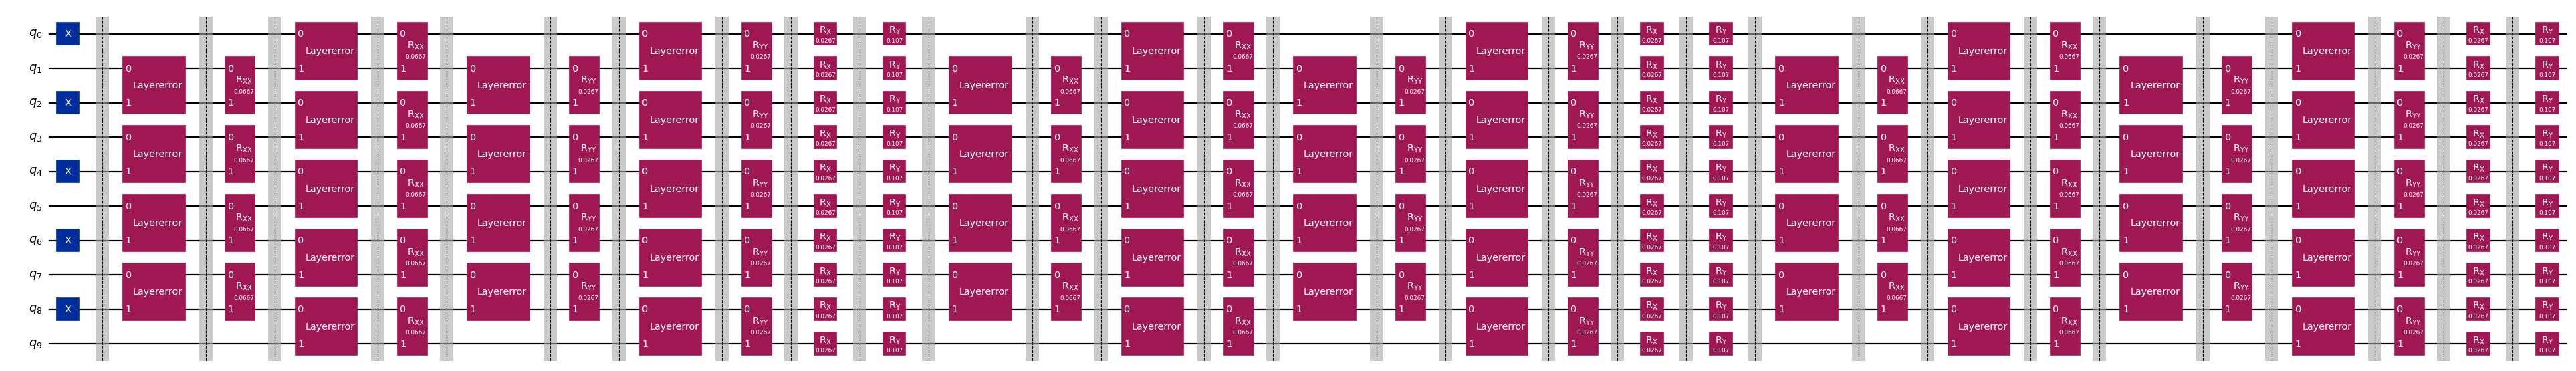

In [11]:
combine_slices(noisy_slices, include_barriers=True).draw("mpl", fold=100, scale=0.8)

At this point, computing the expectation value works exactly the same as before, just

In [12]:
vacuum_state_noisy_obs, _, metadata = backpropagate(obs, noisy_slices)

In [13]:
vacuum_state_noisy_obs.coeffs[~vacuum_state_noisy_obs.paulis.x.any(axis=1)].sum()

np.complex128(-0.5914961069401488-5.206661572048216e-19j)

And we can use Qiskit's `DensityMatrix` as a sanity check:

In [14]:
from qiskit.quantum_info import DensityMatrix

DensityMatrix(combine_slices(noisy_slices)).expectation_value(obs)

np.complex128(-0.5914959200198768+0j)